In [1]:
# imports
import os
import pandas as pd
import numpy as np
import itertools

from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import pylab as pl
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime

%matplotlib inline

/Users/Valcer/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load Data

In [2]:
# load data
data = pd.read_csv('VIX-Data-with-sentiment.csv')

In [3]:
data.head()

,Date,XIV,SPX,10-Day-Rank,50-Day-Rank,10-Day-Range,50-Day-Range,Percent-Change,Volume,Vol_30D,...,Vix-Close,VVIX,UX1,UX2,Contango,Futures-Percent,compound,neg,pos,VIX-Spike
0,1/3/11,12.380,1257.62,4.0,4.0,13.68,81.11,1.13,863689088.0,11.21,...,17.94,86.36,19.40,21.25,1.0,0.095361,0.288014,0.058143,0.197286,0
1,1/4/11,12.135,1272.95,1.0,1.0,23.52,94.62,-0.13,836051392.0,11.20,...,17.34,84.80,19.15,21.20,1.0,0.107050,0.203437,0.096000,0.175625,0
2,1/5/11,12.599,1268.78,2.0,2.0,18.29,94.62,0.50,817246848.0,10.00,...,17.81,85.25,19.15,21.40,1.0,0.117493,0.239340,0.099500,0.231400,1
3,1/6/11,12.526,1276.29,1.0,1.0,21.63,97.96,-0.21,888521856.0,9.36,...,16.80,84.70,18.55,20.65,1.0,0.113208,-0.000964,0.094727,0.099727,1
4,1/7/11,12.508,1274.41,2.0,2.0,21.63,97.96,-0.18,864579584.0,8.97,...,17.31,84.60,18.60,20.85,1.0,0.120968,0.133800,0.075556,0.175889,0


In [4]:
# split data into X
X = data[['XIV','SPX','10-Day-Rank','50-Day-Rank','10-Day-Range', 
          '50-Day-Range', 'Percent-Change','Volume','Vol_30D',
          'Impl_vol_50D','Impl_vol_25D','Impl_vol_40D','Impl_vol 75D',
          'Vix-Open','VVIX','UX1','UX2','Contango',
          'Futures-Percent','compound','neg','pos']]

In [5]:
X.head()

,XIV,SPX,10-Day-Rank,50-Day-Rank,10-Day-Range,50-Day-Range,Percent-Change,Volume,Vol_30D,Impl_vol_50D,...,Impl_vol 75D,Vix-Open,VVIX,UX1,UX2,Contango,Futures-Percent,compound,neg,pos
0,12.380,1257.62,4.0,4.0,13.68,81.11,1.13,863689088.0,11.21,13.52,...,15.57,17.61,86.36,19.40,21.25,1.0,0.095361,0.288014,0.058143,0.197286
1,12.135,1272.95,1.0,1.0,23.52,94.62,-0.13,836051392.0,11.20,13.42,...,15.38,17.38,84.80,19.15,21.20,1.0,0.107050,0.203437,0.096000,0.175625
2,12.599,1268.78,2.0,2.0,18.29,94.62,0.50,817246848.0,10.00,12.65,...,14.41,17.02,85.25,19.15,21.40,1.0,0.117493,0.239340,0.099500,0.231400
3,12.526,1276.29,1.0,1.0,21.63,97.96,-0.21,888521856.0,9.36,13.44,...,15.29,17.40,84.70,18.55,20.65,1.0,0.113208,-0.000964,0.094727,0.099727
4,12.508,1274.41,2.0,2.0,21.63,97.96,-0.18,864579584.0,8.97,12.67,...,14.47,17.14,84.60,18.60,20.85,1.0,0.120968,0.133800,0.075556,0.175889


In [6]:
# split data into y
y = data[['VIX-Spike']]

In [7]:
y.head()

,VIX-Spike
0,0
1,0
2,1
3,1
4,0


### Train/Test Split

In [8]:
# split into train and test
X_train_split = X[:1368]
X_test_split = X[1368:]
y_train_split = y[:1368]
y_test_split = y[1368:]

In [9]:
X_train_split.head()

,XIV,SPX,10-Day-Rank,50-Day-Rank,10-Day-Range,50-Day-Range,Percent-Change,Volume,Vol_30D,Impl_vol_50D,...,Impl_vol 75D,Vix-Open,VVIX,UX1,UX2,Contango,Futures-Percent,compound,neg,pos
0,12.380,1257.62,4.0,4.0,13.68,81.11,1.13,863689088.0,11.21,13.52,...,15.57,17.61,86.36,19.40,21.25,1.0,0.095361,0.288014,0.058143,0.197286
1,12.135,1272.95,1.0,1.0,23.52,94.62,-0.13,836051392.0,11.20,13.42,...,15.38,17.38,84.80,19.15,21.20,1.0,0.107050,0.203437,0.096000,0.175625
2,12.599,1268.78,2.0,2.0,18.29,94.62,0.50,817246848.0,10.00,12.65,...,14.41,17.02,85.25,19.15,21.40,1.0,0.117493,0.239340,0.099500,0.231400
3,12.526,1276.29,1.0,1.0,21.63,97.96,-0.21,888521856.0,9.36,13.44,...,15.29,17.40,84.70,18.55,20.65,1.0,0.113208,-0.000964,0.094727,0.099727
4,12.508,1274.41,2.0,2.0,21.63,97.96,-0.18,864579584.0,8.97,12.67,...,14.47,17.14,84.60,18.60,20.85,1.0,0.120968,0.133800,0.075556,0.175889


In [10]:
y_test_split.head()

,VIX-Spike
1368,0
1369,0
1370,0
1371,0
1372,0


In [11]:
# clean up selections
y = np.array(y)
y = y.reshape(y.shape[0],-1)
y_train_split = np.array(y_train_split)
y_train_split = y_train_split.reshape(y_train_split.shape[0],-1)
y_test_split = np.array(y_test_split)
y_test_split = y_test_split.reshape(y_test_split.shape[0],-1)

### Feature Plotting

In [12]:
# # VIX-Open vs VIX-Close
# X_blue = data[['Vix-Open','Vix-Close']]
# sns.pairplot(X_blue)

In [13]:
# VIX-Open vs VIX-Close -- color coded


## XGBoost

### Grid Search

In [14]:
# grid search -- use educated guesses for parameter values

rand_grid = [
            {
                'learning_rate':[0.1], 
                'n_estimators':[200],
                'max_depth':[20], 
                'min_child_weight':[3], 
                'gamma':[0], 
                'subsample':[1], 
                'colsample_bytree':[0.8],   
                'reg_alpha':[0.01]
            }
            ]

In [15]:
xgb_model = XGBClassifier(objective='binary:logistic',scale_pos_weight=1,
                          nthread=-1,seed=27)
# xgb_model.set_params()
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

In [16]:
# run grid search
clf = GridSearchCV(estimator=xgb_model, param_grid=rand_grid, 
                   scoring='recall', n_jobs=4, cv=None, verbose=True)

In [17]:
# fit on all testing data
y = np.reshape(y, newshape=-1)
grid_result = clf.fit(X, y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    1.5s finished


### Cross Validation Results

In [18]:
# best params
clf.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 20,
 'min_child_weight': 3,
 'n_estimators': 200,
 'reg_alpha': 0.01,
 'subsample': 1}

In [19]:
# best params
grid_result.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 20,
 'min_child_weight': 3,
 'n_estimators': 200,
 'reg_alpha': 0.01,
 'subsample': 1}

In [20]:
# summarize results
print ('CV results: ', grid_result.cv_results_)
print ('at index ', grid_result.best_index_)
print ('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

CV results:  {'split0_test_score': array([ 0.]), 'split1_test_score': array([ 0.02608696]), 'split2_test_score': array([ 0.19130435]), 'mean_test_score': array([ 0.07242264]), 'std_test_score': array([ 0.0846987]), 'rank_test_score': array([1], dtype=int32), 'split0_train_score': array([ 0.97391304]), 'split1_train_score': array([ 0.97402597]), 'split2_train_score': array([ 1.]), 'mean_train_score': array([ 0.98264634]), 'std_train_score': array([ 0.01227098]), 'mean_fit_time': array([ 1.17242273]), 'std_fit_time': array([ 0.30196376]), 'mean_score_time': array([ 0.01108448]), 'std_score_time': array([ 0.00169971]), 'param_colsample_bytree': masked_array(data = [0.8],
             mask = [False],
       fill_value = ?)
, 'param_gamma': masked_array(data = [0],
             mask = [False],
       fill_value = ?)
, 'param_learning_rate': masked_array(data = [0.1],
             mask = [False],
       fill_value = ?)
, 'param_max_depth': masked_array(data = [20],
             mask = [False

### XGBoost - Fit Model on Best Params

In [21]:
# fit model on auc predictions on entire training dataset
xgb_online = XGBClassifier(objective='binary:logistic',
                                scale_pos_weight=1,nthread=-1,seed=27,
                                learning_rate=grid_result.best_params_['learning_rate'], 
                                n_estimators=grid_result.best_params_['n_estimators'],
                                max_depth=grid_result.best_params_['max_depth'], 
                                min_child_weight=grid_result.best_params_['min_child_weight'],
                                gamma=grid_result.best_params_['gamma'],
                                subsample=grid_result.best_params_['subsample'], 
                                colsample_bytree=grid_result.best_params_['colsample_bytree'], 
                                reg_alpha=grid_result.best_params_['reg_alpha'])

### Online Updates

In [22]:
X.shape[0]

1762

In [23]:
y_pred = []

In [24]:
y.shape

(1762,)

In [25]:
startIdx = 500
windowSize = 500
for rowIdx in range(startIdx, X.shape[0]-1):
#     define train and test set
    X_train = X.loc[rowIdx-windowSize:rowIdx-1,:]
    y_train = y[rowIdx-windowSize:rowIdx]
    X_test = X.loc[[rowIdx]]
    y_test = y[rowIdx]
#     print(len(y_train))
#     print(X_train.shape)
#     print(X_train)
#     fit xgb model on training data
    xgb_online.fit(X_train, y_train, eval_metric='auc')
#     make predictions
    y_pred.append(xgb_online.predict(X_test))
#     display progress
    if (rowIdx%100==0):
        print (rowIdx)

500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


In [26]:
# reshape
y_pred = np.array(y_pred).flatten()
y_test = y[501:]

In [27]:
y_pred.shape

(1261,)

In [28]:
y_test.shape

(1261,)

#### Running Values

In [29]:
recall_list = []
precision_list = []
non_error_list = []

In [30]:
def findRates(y_test_cfm, y_pred_cfm):
    cfm = confusion_matrix(y_test_cfm, y_pred_cfm)

#     print (cfm)
    
    tp, fp, fn, tn = cfm.ravel()

    recall_rate = tp / (tp + fn)
    precision_rate = tp / (tp + fp)
    error_rate = (fp + fn) / (tp + fp + fn + tn)
    non_error_rate = 1 - error_rate
    
    return [recall_rate, precision_rate, non_error_rate]

In [31]:
for idx in range(y_test.shape[0]-1):
    
#     print ('idx', idx)
#     print ('y_test', str(y_test[:idx+2]))
#     print ('y_pred', str(y_pred[:idx+2]))
    
    accuracy_list = findRates(y_test[:idx+2], y_pred[:idx+2])
    
    recall_list.append(accuracy_list[0])
    precision_list.append(accuracy_list[1])
    non_error_list.append(accuracy_list[2])

In [32]:
recall_list = np.array(recall_list).flatten()
recall_list.shape

(1260,)

In [33]:
precision_list = np.array(precision_list).flatten()
precision_list.shape

(1260,)

In [34]:
non_error_list = np.array(non_error_list).flatten()
non_error_list.shape

(1260,)

#### Plot results

In [35]:
x_axis = np.arange(1260)

/Users/Valcer/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


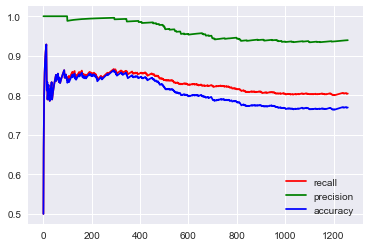

In [36]:
plt.gca().set_color_cycle(['red', 'green', 'blue', 'yellow'])

plt.plot(x_axis, recall_list)
plt.plot(x_axis, precision_list)
plt.plot(x_axis, non_error_list)

plt.legend(['recall', 'precision', 'accuracy'], loc='lower right')

#### Final Values

In [37]:
confusion_matrix(y_test, y_pred)

array([[946,  61],
       [230,  24]])

In [38]:
accuracy_list = findRates(y_test, y_pred)

recall_rate_final = accuracy_list[0]
precision_rate_final = accuracy_list[1]
error_rate_final = accuracy_list[2]

In [39]:
recall_rate_final

0.80442176870748294

In [40]:
precision_rate_final

0.93942403177755707

In [41]:
1 - error_rate_final

0.23076923076923084

In [42]:
y_pred = y_pred.astype(int)
np.savetxt('xgb_preds.csv', y_pred, delimiter=',')

## Random Forest

### Grid Search

In [43]:
# grid search -- use educated guesses for parameter values

rand_grid = [
            {
                'n_estimators':[250],
                'max_features':[16],
                'max_depth':[15]
            }
            ]

In [44]:
rf_model = RandomForestClassifier(bootstrap=True, class_weight=None,
                                  criterion='gini', n_jobs=4, verbose=1)
# xgb_model.set_params()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

In [45]:
# run grid search
clf_rf = GridSearchCV(estimator=rf_model, param_grid=rand_grid, 
                   scoring='recall', n_jobs=4, cv=kfold, verbose=True)

In [46]:
# fit on all testing data
y = np.reshape(y, newshape=-1)
grid_result = clf_rf.fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/Valcer/anaconda/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x105794150, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/Valcer/anaconda/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/Valcer/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/Valce.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x105794150, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/Valcer/anaconda/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/Valcer/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/Valce.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()
     17 
     18 
     19 
     20 

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 5
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 5), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 5)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=5)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '# fit on all testing data\ny = np.reshape(y, newshape=-1)\ngrid_result = clf_rf.fit(X, y)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 12, 14, 20, 11, 33, 360211, tzinfo=datetime.timezone.utc), 'msg_id': '560D30DD82A94AE38DDFA54591300242', 'msg_type': 'execute_request', 'session': 'D659EEF921B844AE8B9083C3EF4478AC', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '560D30DD82A94AE38DDFA54591300242', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'D659EEF921B844AE8B9083C3EF4478AC']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '# fit on all testing data\ny = np.reshape(y, newshape=-1)\ngrid_result = clf_rf.fit(X, y)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 12, 14, 20, 11, 33, 360211, tzinfo=datetime.timezone.utc), 'msg_id': '560D30DD82A94AE38DDFA54591300242', 'msg_type': 'execute_request', 'session': 'D659EEF921B844AE8B9083C3EF4478AC', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '560D30DD82A94AE38DDFA54591300242', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'D659EEF921B844AE8B9083C3EF4478AC'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '# fit on all testing data\ny = np.reshape(y, newshape=-1)\ngrid_result = clf_rf.fit(X, y)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 12, 14, 20, 11, 33, 360211, tzinfo=datetime.timezone.utc), 'msg_id': '560D30DD82A94AE38DDFA54591300242', 'msg_type': 'execute_request', 'session': 'D659EEF921B844AE8B9083C3EF4478AC', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '560D30DD82A94AE38DDFA54591300242', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='# fit on all testing data\ny = np.reshape(y, newshape=-1)\ngrid_result = clf_rf.fit(X, y)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '# fit on all testing data\ny = np.reshape(y, newshape=-1)\ngrid_result = clf_rf.fit(X, y)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('# fit on all testing data\ny = np.reshape(y, newshape=-1)\ngrid_result = clf_rf.fit(X, y)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('# fit on all testing data\ny = np.reshape(y, newshape=-1)\ngrid_result = clf_rf.fit(X, y)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# fit on all testing data\ny = np.reshape(y, newshape=-1)\ngrid_result = clf_rf.fit(X, y)', store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>], cell_name='<ipython-input-46-f05dbeaed07d>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1147970b8, execution_..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x114161270, file "<ipython-input-46-f05dbeaed07d>", line 3>
        result = <ExecutionResult object at 1147970b8, execution_..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x114161270, file "<ipython-input-46-f05dbeaed07d>", line 3>, result=<ExecutionResult object at 1147970b8, execution_..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x114161270, file "<ipython-input-46-f05dbeaed07d>", line 3>
        self.user_global_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "# imports\nimport os\nimport pandas as pd\nimport n...atetime\n\nget_ipython().magic('matplotlib inline')", "# load data\ndata = pd.read_csv('VIX-Data-with-sentiment.csv')", 'data.head()', "# split data into X\nX = data[['XIV','SPX','10-Da...       'Futures-Percent','compound','neg','pos']]", 'X.head()', "# split data into y\ny = data[['VIX-Spike']]", 'y.head()', '# split into train and test\nX_train_split = X[:1...\ny_train_split = y[:1368]\ny_test_split = y[1368:]', 'X_train_split.head()', 'y_test_split.head()', '# clean up selections\ny = np.array(y)\ny = y.resh... = y_test_split.reshape(y_test_split.shape[0],-1)', "# # VIX-Open vs VIX-Close\n# X_blue = data[['Vix-Open','Vix-Close']]\n# sns.pairplot(X_blue)", '# VIX-Open vs VIX-Close -- color coded', "# grid search -- use educated guesses for parame...   'reg_alpha':[0.01]\n            }\n            ]", "xgb_model = XGBClassifier(objective='binary:logi...edKFold(n_splits=5, shuffle=True, random_state=7)", "# run grid search\nclf = GridSearchCV(estimator=x...coring='recall', n_jobs=4, cv=None, verbose=True)", '# fit on all testing data\ny = np.reshape(y, newshape=-1)\ngrid_result = clf.fit(X, y)', '# best params\nclf.best_params_', '# best params\ngrid_result.best_params_', ...], 'Out': {3:      Date     XIV      SPX  10-Day-Rank  50-Day-... 
4  0.175889          0  

[5 rows x 25 columns], 5:       XIV      SPX  10-Day-Rank  50-Day-Rank  10...  
4  0.075556  0.175889  

[5 rows x 22 columns], 7:    VIX-Spike
0          0
1          0
2          1
3          1
4          0, 9:       XIV      SPX  10-Day-Rank  50-Day-Rank  10...  
4  0.075556  0.175889  

[5 rows x 22 columns], 10:       VIX-Spike
1368          0
1369          0
1370          0
1371          0
1372          0, 18: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 20, 'min_child_weight': 3, 'n_estimators': 200, 'reg_alpha': 0.01, 'subsample': 1}, 19: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 20, 'min_child_weight': 3, 'n_estimators': 200, 'reg_alpha': 0.01, 'subsample': 1}, 22: 1762, 24: (1762,), 27: (1261,), ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'SVC': <class 'sklearn.svm.classes.SVC'>, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, 'X':            XIV      SPX  10-Day-Rank  50-Day-Ran...N       NaN       NaN  

[1762 rows x 22 columns], 'XGBClassifier': <class 'xgboost.sklearn.XGBClassifier'>, 'X_test':       XIV  SPX  10-Day-Rank  50-Day-Rank  10-Day... NaN       NaN  NaN  NaN  

[1 rows x 22 columns], 'X_test_split':          XIV      SPX  10-Day-Rank  50-Day-Rank ...aN       NaN       NaN  

[394 rows x 22 columns], ...}
        self.user_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "# imports\nimport os\nimport pandas as pd\nimport n...atetime\n\nget_ipython().magic('matplotlib inline')", "# load data\ndata = pd.read_csv('VIX-Data-with-sentiment.csv')", 'data.head()', "# split data into X\nX = data[['XIV','SPX','10-Da...       'Futures-Percent','compound','neg','pos']]", 'X.head()', "# split data into y\ny = data[['VIX-Spike']]", 'y.head()', '# split into train and test\nX_train_split = X[:1...\ny_train_split = y[:1368]\ny_test_split = y[1368:]', 'X_train_split.head()', 'y_test_split.head()', '# clean up selections\ny = np.array(y)\ny = y.resh... = y_test_split.reshape(y_test_split.shape[0],-1)', "# # VIX-Open vs VIX-Close\n# X_blue = data[['Vix-Open','Vix-Close']]\n# sns.pairplot(X_blue)", '# VIX-Open vs VIX-Close -- color coded', "# grid search -- use educated guesses for parame...   'reg_alpha':[0.01]\n            }\n            ]", "xgb_model = XGBClassifier(objective='binary:logi...edKFold(n_splits=5, shuffle=True, random_state=7)", "# run grid search\nclf = GridSearchCV(estimator=x...coring='recall', n_jobs=4, cv=None, verbose=True)", '# fit on all testing data\ny = np.reshape(y, newshape=-1)\ngrid_result = clf.fit(X, y)', '# best params\nclf.best_params_', '# best params\ngrid_result.best_params_', ...], 'Out': {3:      Date     XIV      SPX  10-Day-Rank  50-Day-... 
4  0.175889          0  

[5 rows x 25 columns], 5:       XIV      SPX  10-Day-Rank  50-Day-Rank  10...  
4  0.075556  0.175889  

[5 rows x 22 columns], 7:    VIX-Spike
0          0
1          0
2          1
3          1
4          0, 9:       XIV      SPX  10-Day-Rank  50-Day-Rank  10...  
4  0.075556  0.175889  

[5 rows x 22 columns], 10:       VIX-Spike
1368          0
1369          0
1370          0
1371          0
1372          0, 18: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 20, 'min_child_weight': 3, 'n_estimators': 200, 'reg_alpha': 0.01, 'subsample': 1}, 19: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 20, 'min_child_weight': 3, 'n_estimators': 200, 'reg_alpha': 0.01, 'subsample': 1}, 22: 1762, 24: (1762,), 27: (1261,), ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'SVC': <class 'sklearn.svm.classes.SVC'>, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, 'X':            XIV      SPX  10-Day-Rank  50-Day-Ran...N       NaN       NaN  

[1762 rows x 22 columns], 'XGBClassifier': <class 'xgboost.sklearn.XGBClassifier'>, 'X_test':       XIV  SPX  10-Day-Rank  50-Day-Rank  10-Day... NaN       NaN  NaN  NaN  

[1 rows x 22 columns], 'X_test_split':          XIV      SPX  10-Day-Rank  50-Day-Rank ...aN       NaN       NaN  

[394 rows x 22 columns], ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/Users/Valcer/Desktop/EE 461P/Project/<ipython-input-46-f05dbeaed07d> in <module>()
      1 
      2 
----> 3 
      4 # fit on all testing data
      5 y = np.reshape(y, newshape=-1)
      6 grid_result = clf_rf.fit(X, y)
      7 
      8 
      9 
     10 

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=StratifiedKFold(n_splits=5, rand...core=True,
       scoring='recall', verbose=True), X=           XIV      SPX  10-Day-Rank  50-Day-Ran...N       NaN       NaN  

[1762 rows x 22 columns], y=array([0, 0, 1, ..., 0, 0, 0]), groups=None)
    940 
    941         groups : array-like, with shape (n_samples,), optional
    942             Group labels for the samples used while splitting the dataset into
    943             train/test set.
    944         """
--> 945         return self._fit(X, y, groups, ParameterGrid(self.param_grid))
        self._fit = <bound method BaseSearchCV._fit of GridSearchCV(...ore=True,
       scoring='recall', verbose=True)>
        X =            XIV      SPX  10-Day-Rank  50-Day-Ran...N       NaN       NaN  

[1762 rows x 22 columns]
        y = array([0, 0, 1, ..., 0, 0, 0])
        groups = None
        self.param_grid = [{'max_depth': [15], 'max_features': [16], 'n_estimators': [250]}]
    946 
    947 
    948 class RandomizedSearchCV(BaseSearchCV):
    949     """Randomized search on hyper parameters.

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py in _fit(self=GridSearchCV(cv=StratifiedKFold(n_splits=5, rand...core=True,
       scoring='recall', verbose=True), X=           XIV      SPX  10-Day-Rank  50-Day-Ran...N       NaN       NaN  

[1762 rows x 22 columns], y=array([0, 0, 1, ..., 0, 0, 0]), groups=None, parameter_iterable=<sklearn.model_selection._search.ParameterGrid object>)
    559                                   fit_params=self.fit_params,
    560                                   return_train_score=self.return_train_score,
    561                                   return_n_test_samples=True,
    562                                   return_times=True, return_parameters=True,
    563                                   error_score=self.error_score)
--> 564           for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.model_selection._search.ParameterGrid object>
    565           for train, test in cv_iter)
    566 
    567         # if one choose to see train score, "out" will contain train score info
    568         if self.return_train_score:

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object BaseSearchCV._fit.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Thu Dec 14 14:11:33 2017
PID: 11822                  Python 3.6.1: /Users/Valcer/anaconda/bin/python
...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=1, warm_start=False),            XIV      SPX  10-Day-Rank  50-Day-Ran...N       NaN       NaN  

[1762 rows x 22 columns], array([0, 0, 1, ..., 0, 0, 0]), make_scorer(recall_score), array([   0,    1,    2, ..., 1757, 1758, 1760]), array([   6,   11,   17,   19,   21,   24,   28,...1709, 1715, 1724, 1751, 1754,
       1759, 1761]), True, {'max_depth': 15, 'max_features': 16, 'n_estimators': 250}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=1, warm_start=False),            XIV      SPX  10-Day-Rank  50-Day-Ran...N       NaN       NaN  

[1762 rows x 22 columns], array([0, 0, 1, ..., 0, 0, 0]), make_scorer(recall_score), array([   0,    1,    2, ..., 1757, 1758, 1760]), array([   6,   11,   17,   19,   21,   24,   28,...1709, 1715, 1724, 1751, 1754,
       1759, 1761]), True, {'max_depth': 15, 'max_features': 16, 'n_estimators': 250})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=1, warm_start=False), X=           XIV      SPX  10-Day-Rank  50-Day-Ran...N       NaN       NaN  

[1762 rows x 22 columns], y=array([0, 0, 1, ..., 0, 0, 0]), scorer=make_scorer(recall_score), train=array([   0,    1,    2, ..., 1757, 1758, 1760]), test=array([   6,   11,   17,   19,   21,   24,   28,...1709, 1715, 1724, 1751, 1754,
       1759, 1761]), verbose=True, parameters={'max_depth': 15, 'max_features': 16, 'n_estimators': 250}, fit_params={}, return_train_score=True, return_parameters=True, return_n_test_samples=True, return_times=True, error_score='raise')
    233 
    234     try:
    235         if y_train is None:
    236             estimator.fit(X_train, **fit_params)
    237         else:
--> 238             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseForest.fit of RandomForestClas...e=None,
            verbose=1, warm_start=False)>
        X_train =            XIV      SPX  10-Day-Rank  50-Day-Ran...N       NaN       NaN  

[1408 rows x 22 columns]
        y_train = array([0, 0, 1, ..., 1, 0, 0])
        fit_params = {}
    239 
    240     except Exception as e:
    241         # Note fit time as time until error
    242         fit_time = time.time() - start_time

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py in fit(self=RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=1, warm_start=False), X=           XIV      SPX  10-Day-Rank  50-Day-Ran...N       NaN       NaN  

[1408 rows x 22 columns], y=array([0, 0, 1, ..., 1, 0, 0]), sample_weight=None)
    242         -------
    243         self : object
    244             Returns self.
    245         """
    246         # Validate or convert input data
--> 247         X = check_array(X, accept_sparse="csc", dtype=DTYPE)
        X =            XIV      SPX  10-Day-Rank  50-Day-Ran...N       NaN       NaN  

[1408 rows x 22 columns]
    248         y = check_array(y, accept_sparse='csc', ensure_2d=False, dtype=None)
    249         if issparse(X):
    250             # Pre-sort indices to avoid that each individual tree of the
    251             # ensemble sorts the indices.

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py in check_array(array=array([[  1.23800001e+01,   1.25762000e+03,   4....          nan,              nan]], dtype=float32), accept_sparse=['csc'], dtype=<class 'numpy.float32'>, order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, ensure_min_samples=1, ensure_min_features=1, warn_on_dtype=False, estimator=None)
    402             array = array.astype(np.float64)
    403         if not allow_nd and array.ndim >= 3:
    404             raise ValueError("Found array with dim %d. %s expected <= 2."
    405                              % (array.ndim, estimator_name))
    406         if force_all_finite:
--> 407             _assert_all_finite(array)
        array = array([[  1.23800001e+01,   1.25762000e+03,   4....          nan,              nan]], dtype=float32)
    408 
    409     shape_repr = _shape_repr(array.shape)
    410     if ensure_min_samples > 0:
    411         n_samples = _num_samples(array)

...........................................................................
/Users/Valcer/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py in _assert_all_finite(X=array([[  1.23800001e+01,   1.25762000e+03,   4....          nan,              nan]], dtype=float32))
     53     # everything is finite; fall back to O(n) space np.isfinite to prevent
     54     # false positives from overflow in sum method.
     55     if (X.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(X.sum())
     56             and not np.isfinite(X).all()):
     57         raise ValueError("Input contains NaN, infinity"
---> 58                          " or a value too large for %r." % X.dtype)
        X.dtype = dtype('float32')
     59 
     60 
     61 def assert_all_finite(X):
     62     """Throw a ValueError if X contains NaN or infinity.

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').
___________________________________________________________________________

### Cross Validation Results

In [ ]:
# best params
clf_rf.best_params_

In [ ]:
# best params
grid_result.best_params_

In [ ]:
# summarize results
print ('CV results: ', grid_result.cv_results_)
print ('at index ', grid_result.best_index_)
print ('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

### Random Forest - Fit Model on Best Params

In [ ]:
# fit model on auc predictions on entire training dataset
rf_online = RandomForestClassifier(
                                n_estimators=grid_result.best_params_['n_estimators'],
                                max_depth=grid_result.best_params_['max_depth'], 
                                max_features=grid_result.best_params_['max_features']
                                )

### Online Updates

In [ ]:
X.shape[0]

In [ ]:
y_pred = []

In [ ]:
startIdx = 500
windowSize = 500
for rowIdx in range(startIdx, X.shape[0]-1):
#     define train and test set
    X_train = X.loc[rowIdx-windowSize:rowIdx-1,:]
    y_train = y[rowIdx-windowSize:rowIdx]
    X_test = X.loc[[rowIdx]]
    y_test = y[rowIdx]
#     print(len(y_train))
#     print(X_train.shape)
#     print(X_train)
#     fit xgb model on training data
    rf_online.fit(X_train, y_train)
#     make predictions
    y_pred.append(rf_online.predict(X_test))
#     display progress
    if (rowIdx%10==0):
        print (rowIdx)

In [ ]:
# reshapes
y_pred = np.array(y_pred).flatten()
y_test = y[501:]

In [ ]:
y_pred.shape

In [ ]:
y_test.shape

#### Running Values

In [ ]:
recall_list = []
precision_list = []
non_error_list = []

In [ ]:
def findRates(y_test_cfm, y_pred_cfm):
    cfm = confusion_matrix(y_test_cfm, y_pred_cfm)

#     print (cfm)
    
    tp, fp, fn, tn = cfm.ravel()

    recall_rate = tp / (tp + fn)
    precision_rate = tp / (tp + fp)
    error_rate = (fp + fn) / (tp + fp + fn + tn)
    non_error_rate = 1 - error_rate
    
    return [recall_rate, precision_rate, non_error_rate]

In [ ]:
for idx in range(y_test.shape[0]-1):
    
#     print ('idx', idx)
#     print ('y_test', str(y_test[:idx+2]))
#     print ('y_pred', str(y_pred[:idx+2]))
    
    accuracy_list = findRates(y_test[:idx+2], y_pred[:idx+2])
    
    recall_list.append(accuracy_list[0])
    precision_list.append(accuracy_list[1])
    non_error_list.append(accuracy_list[2])

In [ ]:
recall_list = np.array(recall_list).flatten()
recall_list.shape

In [ ]:
precision_list = np.array(precision_list).flatten()
precision_list.shape

In [ ]:
non_error_list = np.array(non_error_list).flatten()
non_error_list.shape

#### Plot results

In [ ]:
x_axis = np.arange(1260)

In [ ]:
plt.gca().set_color_cycle(['red', 'green', 'blue', 'yellow'])

plt.plot(x_axis, recall_list)
plt.plot(x_axis, precision_list)
plt.plot(x_axis, non_error_list)

plt.legend(['recall', 'precision', 'accuracy'], loc='lower right')

#### Final Values

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
accuracy_list = findRates(y_test, y_pred)

recall_rate_final = accuracy_list[0]
precision_rate_final = accuracy_list[1]
error_rate_final = accuracy_list[2]

In [ ]:
recall_rate

In [ ]:
precision_rate

In [ ]:
1 - error_rate

In [ ]:
y_pred = y_pred.astype(int)
np.savetxt('rf_preds.csv', y_pred, delimiter=',')

## SVM

### Grid Search

In [ ]:
# grid search -- use educated guesses for parameter values

rand_grid = [
            {
                
            }
            ]

In [ ]:
svm_model = SVC()
# xgb_model.set_params()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

In [ ]:
# run grid search
clf_svm = GridSearchCV(estimator=svm_model, param_grid=rand_grid, 
                   scoring='recall', n_jobs=4, cv=kfold, verbose=True)

In [ ]:
# fit on all testing data
y = np.reshape(y, newshape=-1)
grid_result = clf_svm.fit(X, y)

### Cross Validation Results

In [ ]:
# best params

clf_svm.best_params_

In [ ]:
# best params
grid_result.best_params_

In [ ]:
# summarize results
print ('CV results: ', grid_result.cv_results_)
print ('at index ', grid_result.best_index_)
print ('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

### Random Forest - Fit Model on Best Params

In [ ]:
# fit model on auc predictions on entire training dataset
rf_online = RandomForestClassifier(
                                n_estimators=grid_result.best_params_['n_estimators'],
                                max_depth=grid_result.best_params_['max_depth'], 
                                max_features=grid_result.best_params_['max_features']
                                )

### Online Updates

In [ ]:
X.shape[0]

In [ ]:
y_pred = []

In [ ]:
startIdx = 500
for rowIdx in range(startIdx, X.shape[0]-1):
#     define train and test set
    X_train = X.loc[:rowIdx-1,:]
    y_train = y[:rowIdx]
    X_test = X.loc[[rowIdx]]
    y_test = y[rowIdx]
#     print(len(y_train))
#     print(X_train.shape)
#     print(X_train)
#     fit xgb model on training data
    rf_online.fit(X_train, y_train)
#     make predictions
    y_pred.append(rf_online.predict(X_test))
#     display progress
    if (rowIdx%10==0):
        print (rowIdx)

In [ ]:
# reshapes
y_pred = np.array(y_pred).flatten()
y_test = y[501:]

In [ ]:
y_pred.shape

In [ ]:
y_test.shape

#### Running Values

In [ ]:
recall_list = []
precision_list = []
non_error_list = []

In [ ]:
def findRates(y_test_cfm, y_pred_cfm):
    cfm = confusion_matrix(y_test_cfm, y_pred_cfm)

#     print (cfm)
    
    tp, fp, fn, tn = cfm.ravel()

    recall_rate = tp / (tp + fn)
    precision_rate = tp / (tp + fp)
    error_rate = (fp + fn) / (tp + fp + fn + tn)
    non_error_rate = 1 - error_rate
    
    return [recall_rate, precision_rate, non_error_rate]

In [ ]:
for idx in range(y_test.shape[0]-1):
    
#     print ('idx', idx)
#     print ('y_test', str(y_test[:idx+2]))
#     print ('y_pred', str(y_pred[:idx+2]))
    
    accuracy_list = findRates(y_test[:idx+2], y_pred[:idx+2])
    
    recall_list.append(accuracy_list[0])
    precision_list.append(accuracy_list[1])
    non_error_list.append(accuracy_list[2])

In [ ]:
recall_list = np.array(recall_list).flatten()
recall_list.shape

In [ ]:
precision_list = np.array(precision_list).flatten()
precision_list.shape

In [ ]:
non_error_list = np.array(non_error_list).flatten()
non_error_list.shape

#### Plot results

In [ ]:
x_axis = np.arange(1260)

In [ ]:
plt.gca().set_color_cycle(['red', 'green', 'blue', 'yellow'])

plt.plot(x_axis, recall_list)
plt.plot(x_axis, precision_list)
plt.plot(x_axis, non_error_list)

plt.legend(['recall', 'precision', 'accuracy'], loc='lower right')

#### Final Values

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
accuracy_list = findRates(y_test, y_pred)

recall_rate_final = accuracy_list[0]
precision_rate_final = accuracy_list[1]
error_rate_final = accuracy_list[2]

In [ ]:
recall_rate_final

In [ ]:
precision_rate_final

In [ ]:
1 - error_rate_final

In [ ]:
y_pred = y_pred.astype(int)
np.savetxt('rf_preds.csv', y_pred, delimiter=',')

### Write Output to CSV

In [ ]:
# save output
ts = time.time()
file_name = './CrossValidation/output_xgb_' + datetime.datetime.fromtimestamp(ts).strftime('%H-%M-%S')
output_file = open(file_name, 'w')
output_file.write('CV results: %s \n Best index: %s \n Best score: %s \n Best params: %s' 
                  % (grid_result.cv_results_, grid_result.best_index_, 
                     grid_result.best_score_, grid_result.best_params_))

output_file.close()

### XGBoost - Fit Model on Training Set

In [ ]:
# fit model on auc predictions on entire training dataset
xgb_model_final = XGBClassifier(objective='binary:logistic',
                                scale_pos_weight=1,nthread=-1,seed=27,
                                learning_rate=grid_result.best_params_['learning_rate'], 
                                n_estimators=grid_result.best_params_['n_estimators'],
                                max_depth=grid_result.best_params_['max_depth'], 
                                min_child_weight=grid_result.best_params_['min_child_weight'],
                                gamma=grid_result.best_params_['gamma'],
                                subsample=grid_result.best_params_['subsample'], 
                                colsample_bytree=grid_result.best_params_['colsample_bytree'], 
                                reg_alpha=grid_result.best_params_['reg_alpha'])

xgb_model_final.fit(X_train_split, y_train_split, eval_metric='auc')

### Create Confusion Matrix

In [ ]:
y_pred_train = xgb_model_final.predict(X_test_split)

In [ ]:
cf_matrix = confusion_matrix(y_test_split, y_pred_train)

In [ ]:
cf_matrix

In [ ]:
true_pos, false_pos, false_neg, true_neg = cf_matrix.ravel()
print ("Fraction incorrect: ", (false_pos+false_neg) / (true_pos+false_pos+false_neg+true_neg))

In [ ]:
xgb_model_final.feature_importances_

In [ ]:
class_names=['XIV','SPX','Percent-Change','Volume','Vol_30D',
          'Impl_vol_50D','Impl_vol_25D','Impl_vol_40D','Impl_vol_75D',
          'Vix-Open','VVIX','UX1','UX2','Contango',
          'Futures-Percent']

In [ ]:
plt.bar(range(len(xgb_online.feature_importances_)), 
        xgb_online.feature_importances_, color='skyblue')

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, int(cm[i, j]*100)/100.0,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
class_names = ['No Spike','Spike']

In [ ]:
plot_confusion_matrix(cfm, classes=class_names, normalize=False,
                      title='VIX Spike Confusion Matrix for Test Dataset')

### XGBoost  - Fit Final Model on all Data

In [ ]:
# fit XGB according to best model params
xgb_model_final_fit = XGBClassifier(objective='binary:logistic',
                                scale_pos_weight=1,nthread=-1,seed=27,
                                learning_rate=grid_result.best_params_['learning_rate'], 
                                n_estimators=grid_result.best_params_['n_estimators'],
                                max_depth=grid_result.best_params_['max_depth'], 
                                min_child_weight=grid_result.best_params_['min_child_weight'],
                                gamma=grid_result.best_params_['gamma'],
                                subsample=grid_result.best_params_['subsample'], 
                                colsample_bytree=grid_result.best_params_['colsample_bytree'], 
                                reg_alpha=grid_result.best_params_['reg_alpha'])

xgb_model_final_fit.fit(X, y, eval_metric='auc')